In [ ]:
!nvidia-smi

Sat Dec 11 10:18:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from scipy.io import loadmat
import torch as tr
import torch.nn as nn
from time import time
from matplotlib import pyplot as plt
import os
import cv2
from math import ceil
import numpy as np
from tqdm import tqdm
import torchvision
from PIL import Image
import tensorflow as tf

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# device info
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# data paths extraction
# train_rw_path = '/content/drive/MyDrive/HSFMRGB/Prep_02/NTIRE_Train_Clean'
# train_spec_path = '/content/drive/MyDrive/HSFMRGB/Prep_02/NTIRE_Train_Spectral'

train_rw_path = '/content/drive/MyDrive/HSFMRGB/Preprocessed_Datasets/NTIRE_Train_Clean_256'
train_spec_path = '/content/drive/MyDrive/HSFMRGB/Preprocessed_Datasets/NTIRE_Train_Spectral_256'

sp_filename = 'ARAD_HS_'
rw_filename = '_clean'

tsp_paths = os.listdir(train_spec_path)
trw_paths = os.listdir(train_rw_path)[:len(tsp_paths)]
print('train rw paths :',len(trw_paths))
print('train spec paths :',len(tsp_paths))

train rw paths : 450
train spec paths : 450


In [ ]:
img_index = 1
img1 = cv2.imread(os.path.join(train_rw_path,'{}{:04d}{}.png'.format(sp_filename,img_index,rw_filename)))
img_data = loadmat(os.path.join(train_spec_path,'{}{:04d}.mat'.format(sp_filename,img_index)))
img_bands,img2 = img_data['bands'],img_data['cube']
print('RGB image shape :',img1.shape,' || type :',type(img1))
print('Spectral image shape :',img2.shape,' || type :',type(img2))

RGB image shape : (256, 256, 3)  || type : <class 'numpy.ndarray'>
Spectral image shape : (256, 256, 31)  || type : <class 'numpy.ndarray'>


In [ ]:
bands = [400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]

In [ ]:
def getImage(indexs):
  jpgs , specs = [],[]
  for index in indexs:
    jpg = cv2.imread(os.path.join(train_rw_path,'{}{:04d}{}.png'.format(sp_filename,index,rw_filename)))
    data = loadmat(os.path.join(train_spec_path,'{}{:04d}.mat'.format(sp_filename,index)))
    spec = data['cube'][:,:,3:6]
    jpgs.append(jpg)
    specs.append(spec)
  
  jpgs = tr.from_numpy(np.array(jpgs))
  specs = tr.Tensor(specs)
  jpgs = tr.reshape(jpgs,(len(indexs),3,256,256))
  specs = tr.reshape(specs,(len(indexs),3,256,256))
  
  return jpgs,specs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


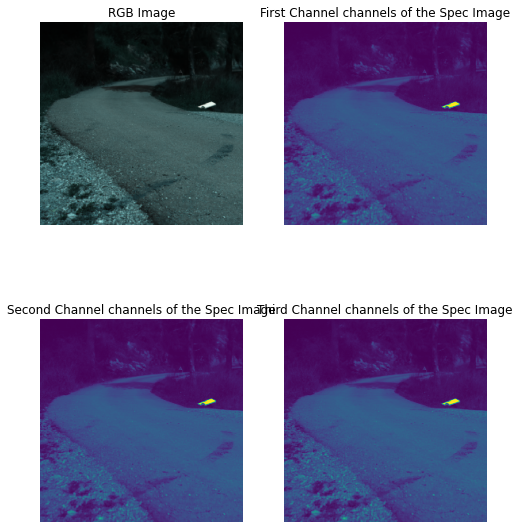

In [ ]:
jpgs,specs = getImage([2])

jpg = tr.reshape(jpgs,(256,256,3))
spec = tr.reshape(specs,(256,256,3))

# plot the pics 
plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
plt.title('RGB Image')
plt.axis('off')
plt.imshow(jpg)

plt.subplot(2,2,2)
plt.title('First Channel channels of the Spec Image')
plt.axis('off')
img = tr.reshape(spec[:,:,:1],(256,256))
plt.imshow(img)

plt.subplot(2,2,3)
plt.title('Second Channel channels of the Spec Image')
plt.axis('off')
img = tr.reshape(spec[:,:,1:2],(256,256))
plt.imshow(img)

plt.subplot(2,2,4)
plt.title('Third Channel channels of the Spec Image')
plt.axis('off')
img = tr.reshape(spec[:,:,2:],(256,256))
plt.imshow(img)
plt.show()

In [ ]:
# Generator Model
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.leaky1 = nn.LeakyReLU(0.2)
    self.leaky2 = nn.LeakyReLU(0.2)
    self.leaky3 = nn.LeakyReLU(0.2)
    self.leaky4 = nn.LeakyReLU(0.2)
   

    self.relu1 = nn.ReLU(inplace=True)
    self.relu2 = nn.ReLU(inplace=True)
    self.relu3 = nn.ReLU(inplace=True)
    self.relu4 = nn.ReLU(inplace=True)
    self.relu5 = nn.ReLU(inplace=True)
  
    self.bn1_64 = nn.BatchNorm2d(64)
    self.bn2_64 = nn.BatchNorm2d(64)

    self.bn1_128 = nn.BatchNorm2d(128)
    self.bn2_128 = nn.BatchNorm2d(128)

    self.bn1_256 = nn.BatchNorm2d(256)
    self.bn2_256 = nn.BatchNorm2d(256)

    self.bn1_512 = nn.BatchNorm2d(512)
    self.bn2_512 = nn.BatchNorm2d(512)
    self.bn3_512 = nn.BatchNorm2d(512)
    self.bn4_512 = nn.BatchNorm2d(512)

    self.drop1 = nn.Dropout(0.5)
    self.drop2 = nn.Dropout(0.5)
    

    self.tanh = nn.Tanh()

    self.conv1 = nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1)
    self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
    self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
    self.conv4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1)
   
    
    self.bottleneck = nn.Conv2d(512,512,kernel_size=4,stride=2,padding=1)

    self.tconv1 = nn.ConvTranspose2d(512,512,kernel_size=4,stride=2,padding=1)
    self.tconv2 = nn.ConvTranspose2d(1024,256,kernel_size=4,stride=2,padding=1) # 1,5
    self.tconv3 = nn.ConvTranspose2d(512,128,kernel_size=4,stride=2,padding=1) # 2,4 
    self.tconv4 = nn.ConvTranspose2d(256,64,kernel_size=4,stride=2,padding=1) # 3,3
  

    self.final = nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1) # 5,1
    
    
  def forward(self,x):
    d1 = self.leaky1(self.conv1(x))
    d2 = self.leaky2(self.bn1_128(self.conv2(d1)))
    d3 = self.leaky3(self.bn1_256(self.conv3(d2)))
    d4 = self.leaky4(self.bn1_512(self.conv4(d3)))
   
    bottleneck = self.drop1(self.relu1(self.bottleneck(d4)))
    
    up1 = self.drop2(self.relu2(self.bn2_512(self.tconv1(bottleneck))))
    up2 = self.relu3(self.bn2_256(self.tconv2(tr.cat([up1,d4],1))))
    up3 = self.relu4(self.bn2_128(self.tconv3(tr.cat([up2,d3],1))))
    up4 = self.relu5(self.bn1_64(self.tconv4(tr.cat([up3,d2],1))))
 
    final = self.tanh(self.final(tr.cat([up4,d1],1)))

    return final


In [ ]:
netG = Generator().to(device)
if __name__ == '__main__':
  with tr.no_grad():
      input = tr.randn((1,3,256,256),device=device)
      start = time()
      output = netG(input)
      end = time()
      print('time :',end-start,'sec')
      print(output.shape)
print(netG)

time : 0.14994072914123535 sec
torch.Size([1, 3, 256, 256])
Generator(
  (leaky1): LeakyReLU(negative_slope=0.2)
  (leaky2): LeakyReLU(negative_slope=0.2)
  (leaky3): LeakyReLU(negative_slope=0.2)
  (leaky4): LeakyReLU(negative_slope=0.2)
  (relu1): ReLU(inplace=True)
  (relu2): ReLU(inplace=True)
  (relu3): ReLU(inplace=True)
  (relu4): ReLU(inplace=True)
  (relu5): ReLU(inplace=True)
  (bn1_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_512): BatchNorm2d(512, eps=1e-05, momentum=0

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.leaky1 = nn.LeakyReLU(0.2)
    self.leaky2 = nn.LeakyReLU(0.2)
    self.leaky3 = nn.LeakyReLU(0.2)
    self.leaky4 = nn.LeakyReLU(0.2)

    self.bn128 = nn.BatchNorm2d(128)
    self.bn256 = nn.BatchNorm2d(256)
    self.bn512 = nn.BatchNorm2d(512)


    self.conv1 = nn.Conv2d(6,64,kernel_size=4,stride=1,padding=1)
    self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
    self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
    self.conv4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1)
    self.final = nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1)

  def forward(self,x):
    d1 = self.leaky1(self.conv1(x))
    d2 = self.leaky2(self.bn128(self.conv2(d1)))
    d3 = self.leaky3(self.bn256(self.conv3(d2)))
    d4 = self.leaky4(self.bn512(self.conv4(d3)))
    final = nn.Sigmoid()(self.final(d4))
    return final

In [ ]:
netD = Discriminator().to(device)
if __name__ == '__main__':
  with tr.no_grad():
    input = tr.randn((1,6,256,256),device=device)
    start = time()
    output = netD(input)
    end = time()
    print('time :',end-start,'sec')
    print(output.shape)
print(netD)

time : 0.015361309051513672 sec
torch.Size([1, 1, 30, 30])
Discriminator(
  (leaky1): LeakyReLU(negative_slope=0.2)
  (leaky2): LeakyReLU(negative_slope=0.2)
  (leaky3): LeakyReLU(negative_slope=0.2)
  (leaky4): LeakyReLU(negative_slope=0.2)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)


In [ ]:
batch_size = 1
lrG = 2e-4
lrD = 2e-4
num_epochs = 20
criterion = nn.BCELoss()
L1 = nn.L1Loss()

optimizerG = tr.optim.Adam(netG.parameters(),lr=lrG,betas=(0.5,0.999))
optimizerD = tr.optim.Adam(netD.parameters(),lr=lrD,betas=(0.5,0.999))
g_scaler = tr.cuda.amp.GradScaler()
d_scaler = tr.cuda.amp.GradScaler()

In [ ]:
# train the model
G_errors , D_errors = [],[]
for epoch in range(num_epochs):
  tG , tD = 0 , 0
  for i in tqdm(range(1,451,batch_size),desc=f'Training.... {epoch}'):
    netD.zero_grad()
    indexs = [j for j in range(i,i+batch_size if i+batch_size <= 451 else 451)]
    jpgs_real,specs_real = getImage(indexs)
    jpgs_real = jpgs_real.to(device)
    specs_real = specs_real.to(device)
    specs_fake = netG(jpgs_real.float())

    concat_real = tr.cat((jpgs_real,specs_real),1)
    real_patch = netD(concat_real)

    concat_fake = tr.cat((jpgs_real,specs_fake),1)
    fake_patch = netD(concat_fake.detach())

    real_label = tr.ones_like(real_patch,dtype=tr.float,device=device)
    real_loss = criterion(real_patch,real_label)
    

    fake_label = tr.zeros_like(fake_patch,dtype=tr.float,device=device)
    fake_loss = criterion(fake_patch,fake_label)
    
    D_loss = (real_loss + fake_loss)/2
    tD += D_loss.item()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(optimizerD)
    d_scaler.update()
    
    netG.zero_grad()
    real_label.fill_(1)
    fake_patch = netD(concat_fake)
    netG_Adv_Loss = criterion(fake_patch,real_label)
    L1_loss = L1(specs_fake,specs_real.to(device))
    G_loss = netG_Adv_Loss + L1_loss*100
    tG += G_loss.item()

    g_scaler.scale(G_loss).backward()
    g_scaler.step(optimizerG)
    g_scaler.update()
    
  G_errors.append(tG)
  D_errors.append(tD)
  print(f'Gloss : {G_errors[-1]}, Dloss : {D_errors[-1]}')

Training.... 0: 100%|██████████| 450/450 [01:24<00:00,  5.33it/s]


Gloss : 12635.758242607117, Dloss : 1.3769656026561279


Training.... 1: 100%|██████████| 450/450 [01:24<00:00,  5.29it/s]


Gloss : 12637.53899383545, Dloss : 2.451253469691437


Training.... 2: 100%|██████████| 450/450 [01:25<00:00,  5.29it/s]


Gloss : 12423.629349708557, Dloss : 13.7475058170985


Training.... 3: 100%|██████████| 450/450 [01:25<00:00,  5.28it/s]


Gloss : 13241.920093536377, Dloss : 2.9296603530310676


Training.... 4: 100%|██████████| 450/450 [01:25<00:00,  5.28it/s]


Gloss : 13240.657165527344, Dloss : 23.14762505228282


Training.... 5: 100%|██████████| 450/450 [01:24<00:00,  5.30it/s]


Gloss : 12423.160320281982, Dloss : 12.968568887103174


Training.... 6: 100%|██████████| 450/450 [01:24<00:00,  5.31it/s]


Gloss : 12528.258454322815, Dloss : 8.472356981343182


Training.... 7: 100%|██████████| 450/450 [01:24<00:00,  5.33it/s]


Gloss : 11912.172933578491, Dloss : 1.1938219172079698


Training.... 8: 100%|██████████| 450/450 [01:24<00:00,  5.32it/s]


Gloss : 11870.551864624023, Dloss : 19.195742098228948


Training.... 9: 100%|██████████| 450/450 [01:24<00:00,  5.32it/s]


Gloss : 12056.825380325317, Dloss : 0.9072645762898901


Training.... 10: 100%|██████████| 450/450 [01:24<00:00,  5.33it/s]


Gloss : 11695.406943321228, Dloss : 0.4874426587648486


Training.... 11: 100%|██████████| 450/450 [01:24<00:00,  5.32it/s]


Gloss : 12852.50749206543, Dloss : 0.6214042525880359


Training.... 12: 100%|██████████| 450/450 [01:25<00:00,  5.27it/s]


Gloss : 12447.542828559875, Dloss : 13.491879571203754


Training.... 13: 100%|██████████| 450/450 [01:25<00:00,  5.29it/s]


Gloss : 12847.677031517029, Dloss : 4.851357666124386


Training.... 14: 100%|██████████| 450/450 [01:24<00:00,  5.32it/s]


Gloss : 11942.098986625671, Dloss : 18.540131135163392


Training.... 15: 100%|██████████| 450/450 [01:24<00:00,  5.29it/s]


Gloss : 11275.629147529602, Dloss : 2.9401678705835366


Training.... 16: 100%|██████████| 450/450 [01:24<00:00,  5.30it/s]


Gloss : 11262.173628807068, Dloss : 0.32227499785949476


Training.... 17: 100%|██████████| 450/450 [01:25<00:00,  5.29it/s]


Gloss : 11416.799158096313, Dloss : 0.2630722705980588


Training.... 18: 100%|██████████| 450/450 [01:24<00:00,  5.31it/s]


Gloss : 11110.112442970276, Dloss : 0.7511867622779391


Training.... 19: 100%|██████████| 450/450 [01:24<00:00,  5.30it/s]

Gloss : 11063.921865463257, Dloss : 14.338246071107278


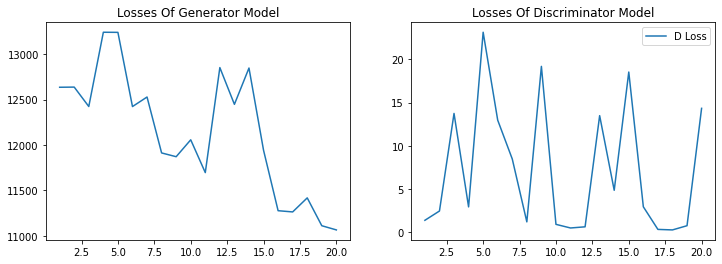

In [ ]:
_x = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Losses Of Generator Model')
plt.plot(_x,G_errors,label='G Loss')

plt.subplot(1,2,2)
plt.title('Losses Of Discriminator Model')
plt.plot(_x,D_errors,label='D Loss')
plt.legend()

plt.show()

In [ ]:
def amply(img):
  return (1+abs(img))*(255/2)

def mod_amply(img):
  for i in range(len(img)):
    for j in range(len(img[0])):
      if img[i][j]>=0:
        img[i][j] = img[i][j]*(255)
  return img

def getMinMax(img):
  mini,maxi = 1000000,-1000000
  for i in range(len(img)):
    for j in range(len(img[0])):
      mini = min(mini,img[i][j])
      maxi = max(maxi,img[i][j])
  return mini,maxi

def remap(img):
  input_start,input_end = getMinMax(img)
  output_start,output_end = 0,255
  slope = (output_end - output_start) / (input_end - input_start)
  output = output_start + (slope * (img - input_start))
  return output

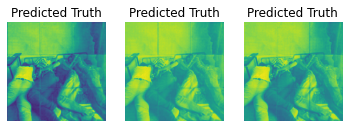

In [ ]:
# apple jpg
img = cv2.imread('/content/drive/MyDrive/HSFMRGB/Imgs/sleep.jpeg')
img = cv2.resize(img,(256,256))
img = tr.reshape(tr.from_numpy(img),(1,3,256,256))
output = netG(img.to(device).float())
output = tr.reshape(output,(256,256,3))

plt.subplot(1,3,1)
plt.title('Predicted Truth')
plt.axis('off')
img = tr.reshape(output[:,:,:1],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(amply(img))

plt.subplot(1,3,2)
plt.title('Predicted Truth')
plt.axis('off')
img = tr.reshape(output[:,:,1:2],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(1,3,3)
plt.title('Predicted Truth')
plt.axis('off')
img = tr.reshape(output[:,:,2:3],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

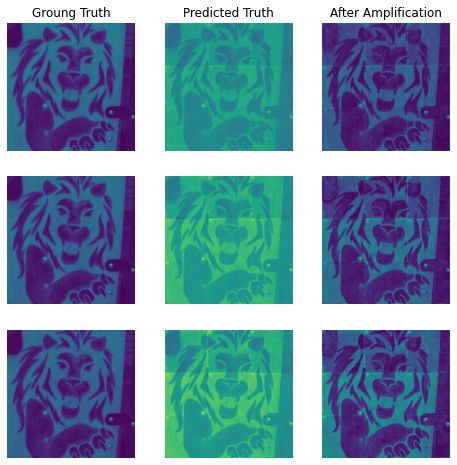

In [ ]:
jpgs,specs = getImage([432])

specs = tr.reshape(specs,(256,256,3))
pred_specs = netG(jpgs.to(device).float())
pred_specs = tr.reshape(pred_specs,(256,256,3))
# jpg = tr.reshape(jpgs,(256,256,3)).to('cpu').detach().numpy()

plt.figure(figsize=(8,8))

plt.subplot(3,3,1)
plt.title('Groung Truth')
plt.axis('off')
img = np.resize(specs[:,:,:1],(256,256))
plt.imshow(img)

plt.subplot(3,3,2)
plt.title('Predicted Truth')
plt.axis('off')
img = tr.reshape(pred_specs[:,:,:1],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(3,3,3)
plt.title('After Amplification')
plt.axis('off')
img = amply(img)
plt.imshow(img)


plt.subplot(3,3,4)
plt.axis('off')
img = np.resize(specs[:,:,1:2],(256,256))
plt.imshow(img)

plt.subplot(3,3,5)
plt.axis('off')
img = tr.reshape(pred_specs[:,:,1:2],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(3,3,6)
plt.axis('off')
img = amply(img)
plt.imshow(img)

plt.subplot(3,3,7)
plt.axis('off')
img = np.resize(specs[:,:,2:],(256,256))
plt.imshow(img)

plt.subplot(3,3,8)
plt.axis('off')
img = tr.reshape(pred_specs[:,:,2:],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(3,3,9)
plt.axis('off')
img = amply(img)
plt.imshow(img)

plt.show()

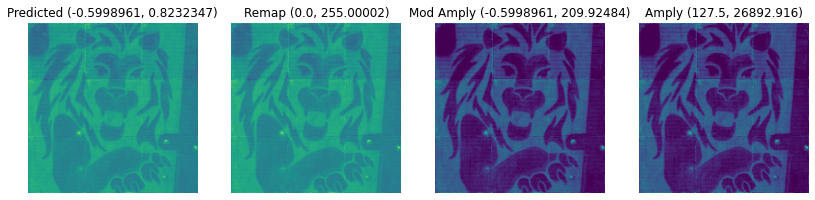

In [ ]:
img = tr.reshape(pred_specs[:,:,:1],(256,256))
img = img.to('cpu').detach().numpy()


plt.figure(figsize=(14,14))
plt.subplot(1,4,1)
plt.title(f'Predicted {getMinMax(img[:,:])}')
plt.axis('off')
plt.imshow(img)



remap_img = remap(img[:,:])
plt.subplot(1,4,2)
plt.title(f'Remap {getMinMax(remap_img)}')
plt.axis('off')
plt.imshow(remap_img)



mod_amply_img = mod_amply(img[:,:])
plt.subplot(1,4,3)
plt.title(f'Mod Amply {getMinMax(mod_amply_img)}')
plt.axis('off')
plt.imshow(mod_amply_img)



amp_img = amply(img[:,:])
plt.subplot(1,4,4)
plt.title(f'Amply {getMinMax(amp_img)}')
plt.axis('off')
plt.imshow(amp_img)

plt.show()

In [ ]:
# tr.save(netG.state_dict(),'netG.pth')

In [ ]:
# tr.save(netD.state_dict(),'netD.pth')

In [ ]:
# load the models
# state_dict = tr.load('/content/drive/MyDrive/netG.pth')
# state_dict = tr.load('/content/drive/MyDrive/HSFMRGB/netG.pth')
state_dict = tr.load('/content/drive/MyDrive/HSFMRGB/Colab Notebooks old/netG-460-480.pth')
print(state_dict.keys())
netG.load_state_dict(state_dict)

# state_dict = tr.load('/content/drive/MyDrive/netD.pth')
# state_dict = tr.load('/content/drive/MyDrive/HSFMRGB/netD.pth')
state_dict = tr.load('/content/drive/MyDrive/HSFMRGB/Colab Notebooks old/netD-460-480.pth')
print(state_dict.keys())
netD.load_state_dict(state_dict)

odict_keys(['bn1_64.weight', 'bn1_64.bias', 'bn1_64.running_mean', 'bn1_64.running_var', 'bn1_64.num_batches_tracked', 'bn2_64.weight', 'bn2_64.bias', 'bn2_64.running_mean', 'bn2_64.running_var', 'bn2_64.num_batches_tracked', 'bn1_128.weight', 'bn1_128.bias', 'bn1_128.running_mean', 'bn1_128.running_var', 'bn1_128.num_batches_tracked', 'bn2_128.weight', 'bn2_128.bias', 'bn2_128.running_mean', 'bn2_128.running_var', 'bn2_128.num_batches_tracked', 'bn1_256.weight', 'bn1_256.bias', 'bn1_256.running_mean', 'bn1_256.running_var', 'bn1_256.num_batches_tracked', 'bn2_256.weight', 'bn2_256.bias', 'bn2_256.running_mean', 'bn2_256.running_var', 'bn2_256.num_batches_tracked', 'bn1_512.weight', 'bn1_512.bias', 'bn1_512.running_mean', 'bn1_512.running_var', 'bn1_512.num_batches_tracked', 'bn2_512.weight', 'bn2_512.bias', 'bn2_512.running_mean', 'bn2_512.running_var', 'bn2_512.num_batches_tracked', 'bn3_512.weight', 'bn3_512.bias', 'bn3_512.running_mean', 'bn3_512.running_var', 'bn3_512.num_batches_

<All keys matched successfully>